In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Scikit-Learn Modules
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## Load California Housing Dataset

In [2]:
def load_data():

    housing_data = fetch_california_housing()
    df = pd.DataFrame(housing_data.data, columns = housing_data.feature_names)
    df['MedHouseVal'] = housing_data.target
    return df

data = load_data()

print(f"Data shape: {data.shape}")
data.head()

Data shape: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## Data Preprocessing

In [3]:
def preprocess_data(df):

    X = df.drop('MedHouseVal', axis = 1)
    y = df['MedHouseVal']

    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y,
        test_size = 0.2,
        random_state = 42,
        shuffle = True
    )

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_data(data)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (16512, 8)
y_train shape: (16512,)
X_test shape: (4128, 8)
y_test shape: (4128,)


## linear Regression Model

In [4]:
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)

    print(f"{model.__class__.__name__} Performance: ")
    print(f"MSE: {round(mse, 3)}")
    print(f"R2 Score: {round(r2, 3)}")
    print(f"MAE: {round(mae, 3)}")
    print("-" * 40)

    return predictions, model

linear_model = LinearRegression()
lr_predictions, linear_model = train_and_evaluate_model(linear_model, X_train, X_test, y_train, y_test)

LinearRegression Performance: 
MSE: 0.556
R2 Score: 0.576
MAE: 0.533
----------------------------------------


## Random Forest Regressor with GridSearchCV

In [5]:
def train_random_forest(X_train, X_test, y_train, y_test):

    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    }

    rf = RandomForestRegressor(random_state = 42)

    grid_search = GridSearchCV(
        estimator = rf,
        param_grid = param_grid,
        cv = 3,
        n_jobs = -1,
        scoring = 'r2',
        verbose = 1
    )

    grid_search.fit(X_train, y_train)
    best_rf = grid_search.best_estimator_
    predictions = best_rf.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)

    print("Best Parameters:", grid_search.best_params_)
    print("Random Forest Performance:")
    print("MSE:", round(mse, 3))
    print("R2 Score:", round(r2, 3))
    print("MAE:", round(mae, 3))
    print("-" * 40)

    return predictions, best_rf

rf_predictions, best_rf_model = train_random_forest(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest Performance:
MSE: 0.253
R2 Score: 0.807
MAE: 0.327
----------------------------------------


## Feature Importance & Residual Analysis

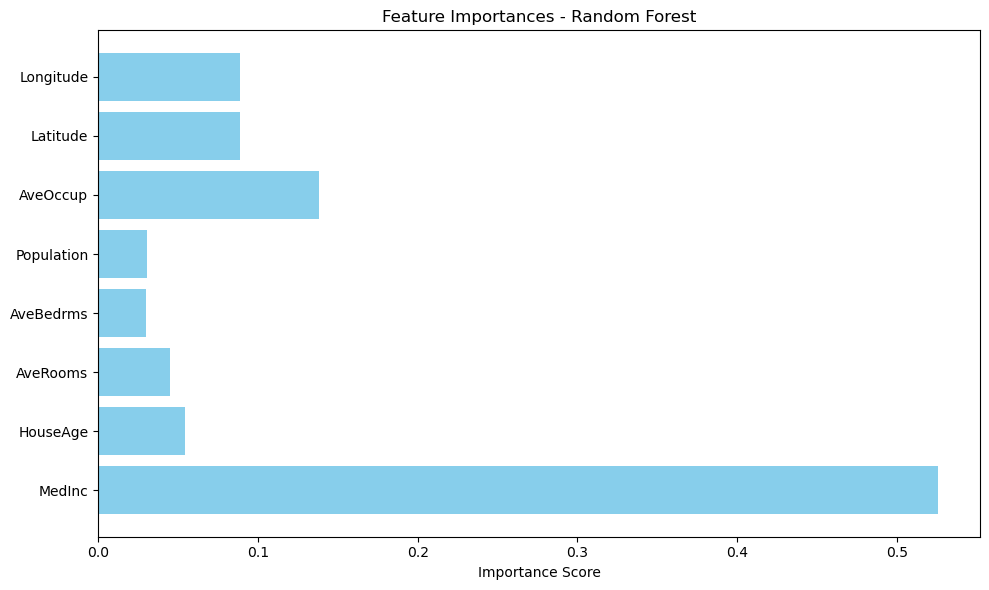

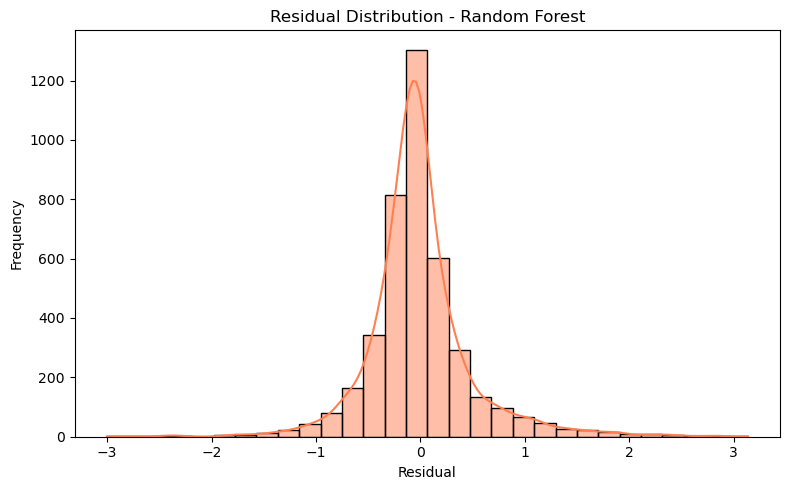

In [6]:
os.makedirs("images", exist_ok = True)

importances = best_rf_model.feature_importances_
features = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances, color="skyblue")
plt.title("Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("images/feature_importance.png")
plt.show()

# Residuals
residuals = y_test - rf_predictions
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color="coral")
plt.title("Residual Distribution - Random Forest")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("images/residuals_plot.png")
plt.show()

## Conclusion

- **Linear Regression** achieved an R² score of ~0.57 with a MAE of ~$53,000.
- **Random Forest Regressor**, after tuning with GridSearchCV, significantly improved performance to an R² of ~0.81 and MAE of ~$33,000.
- Feature importance analysis showed that **Median Income** was the most influential variable, as expected.
- Residual analysis showed that the Random Forest model’s errors are generally well-distributed, indicating stable generalization.

This project demonstrates end-to-end regression modeling, hyperparameter tuning, and evaluation using real-world housing data.
